# Лабораторная работа №3. Бутстрап-оценки
---
Выполнили студенты:
<div align="center">
гр. J3112, Тиганов Вадим Игоревич, ИСУ: 467701<br>
гр. J3113, Бессонов Александр Русланович, ИСУ: 465220
</div>

---
### Цель: Изучение метода бутстрапа для оценки статистических характеристик данных и построения доверительных интервалов.
---
#### Задачи: 
##### 1. Генерация данных и базовые оценки
##### 2. Применение бутстрапа для точечных оценок
##### 3. Построение доверительных интервалов
##### 4. Исследование влияния параметров N и B *(изучить зависимость ширины доверительного интервала от объема выборки (N). Исследовать влияние числа бутстрап-итераций (B) на точность оценки интервала.)*
##### 5. Проверка покрытия доверительных интервалов
##### 6. Документирование результатов и визуальное представление где требуется

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pandas as pd
from tqdm import tqdm

### Основные понятия:
---
1. Точечная и выборочная оценка.\
Точечная оценка строится на основании всего набора данных, а выборочное - на основании некой подвыборки из всего набора для оценки среднего всей популяции.
2. Бустрап-оценки\
Из исходного набора данных случайным образом выбираются *n* элементов, которые составят бутстрап-выборку. На основании каждой такой выборки вычисляется ее статистика;\
полученные результаты образуют эмпирическое распределение статистик на наборе данных;\
на их основании можно оценить стандартную ошибку, построить доверительные интервалы.
3. Ядерная оценка плотности *(KDE)* - данные *"сглаживаются"* с помощью ядра (Гауссовского). Ширина полосы контролирует область влияния каждой точки, которая представляет собой данные, и влияет на результат.
4. Доверительный интервал - это диапазон значений, который с определенной вероятностью содержит истинное значение статистики для набора данных. С помощью процентилей определяется верхняя и нижняя граница (среднее процентилей $Q_\alpha$ и $Q_{1 - \alpha}$ )
5. Процентиль - это значение, ниже которого находится определенный процент $p$ значений из выборки для процентился $Q_p$
6. IQR - межквартальный размах - разница между $Q_3 - Q_1$  (75% vs 25%)

### 1. Генерация данных и базовые оценки
Было выбрано нормальное распределение.
$$
f(x) = \frac{1}{\sqrt{2\pi}\sigma} e ^ {-\frac{(x - \mu)^2}{2\sigma^2}}
$$
Сгенерируйте выборку объема N = 500 из непрерывного распределения с произвольными
параметрами (см. описание предыдущей лабораторной работы)

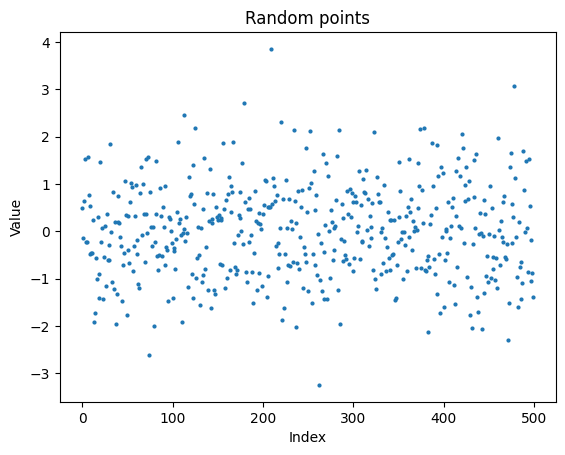

In [20]:
N = 500

np.random.seed(42)

x = np.random.randn(N, 1)

plt.plot(x, 'o', markersize=2)
plt.title('Random points')
plt.xlabel('Index')
plt.ylabel('Value')
plt.show()

Рассчитайте точечные оценки:\
• Выборочное среднее, медиану, дисперсию, интерквартильный размах (IQR)\
• Постройте теоретеческие значения этих величин и сравните точечные оценку с теоре-\
тическими значениями.

Теоретическое значение среднего:
$$ X_{mean} = \frac{1}{N} \cdot \sum_{i=1}^{N} X_i $$

Теоретическое значение медианы:
Для нормального распределения теоретическая медиана совпадает с математическим ожиданием $\mu $

Теоретическое значение дисперсии:
$$ \sigma^2 = { \frac{1}{N} \cdot \sum_{i=1}^{N} (X_i - \mu)^2 } $$

Теоретическое значение интерквартильного размаха (IQR):
Для нормального распределения IQR рассчитывается как разность между 75-м и 25-м процентилями:
$$ IQR = Q3 - Q1 $$
Процентиль $Q_p$ — это значение, ниже которого находится $p$ процентов наблюдений в выборке.

In [21]:
mean = 0  # среднее
std_dev = 1  # стандартное отклонение
N = 500  # объем выборки

# Генерация выборки из нормального распределения
sample = np.random.normal(loc=mean, scale=std_dev, size=N)

In [22]:
# Точечные оценки
sample_mean = np.mean(sample)
sample_median = np.median(sample)
sample_variance = np.var(sample, ddof=1)
sample_iqr = np.percentile(sample, 75) - np.percentile(sample, 25)

In [23]:
# Теоретические значения для нормального распределения
theoretical_mean = mean
theoretical_median = mean
theoretical_variance = std_dev ** 2
theoretical_iqr = stats.norm.ppf(0.75) - stats.norm.ppf(0.25)  # для нормального распределения

Выборочное среднее: 0.031826117056003425, Теоретическое среднее: 0
Медиана: 0.02853159953263933, Теоретическая медиана: 0
Дисперсия: 0.9564785137710892, Теоретическая дисперсия: 1
Интерквартильный размах: 1.2465340374156173, Теоретический IQR: 1.3489795003921634


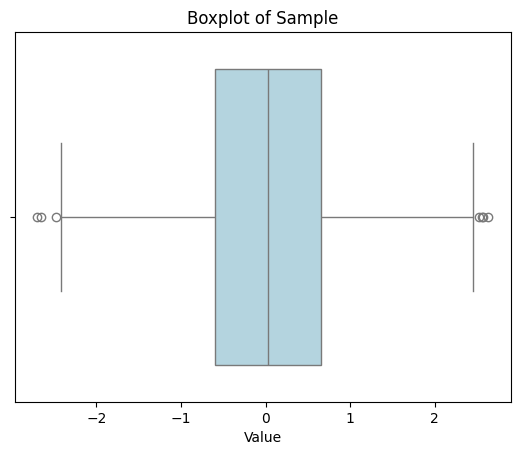

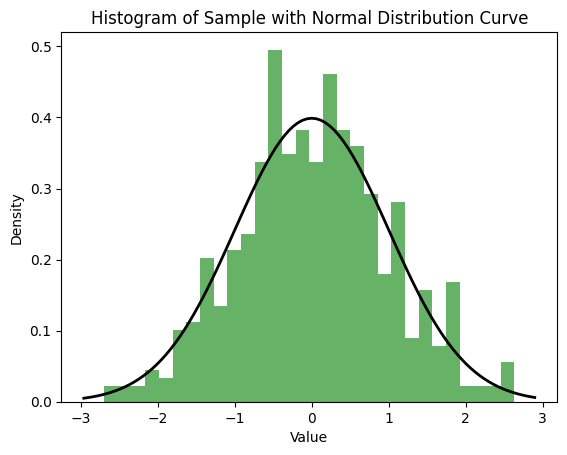

In [24]:
print(f"Выборочное среднее: {sample_mean}, Теоретическое среднее: {theoretical_mean}")
print(f"Медиана: {sample_median}, Теоретическая медиана: {theoretical_median}")
print(f"Дисперсия: {sample_variance}, Теоретическая дисперсия: {theoretical_variance}")
print(f"Интерквартильный размах: {sample_iqr}, Теоретический IQR: {theoretical_iqr}")

sns.boxplot(x=sample, color='lightblue')
plt.title('Boxplot of Sample')
plt.xlabel('Value')
plt.show()

plt.hist(sample, bins=30, density=True, alpha=0.6, color='g')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mean, std_dev)
plt.plot(x, p, 'k', linewidth=2)
plt.title('Histogram of Sample with Normal Distribution Curve')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()

Постройте гистограмму данных с наложением ядерной оценки плотности (KDE). Сравните
KDE с гистограммой при разном числе бинов (3 значения, заданные вручную).

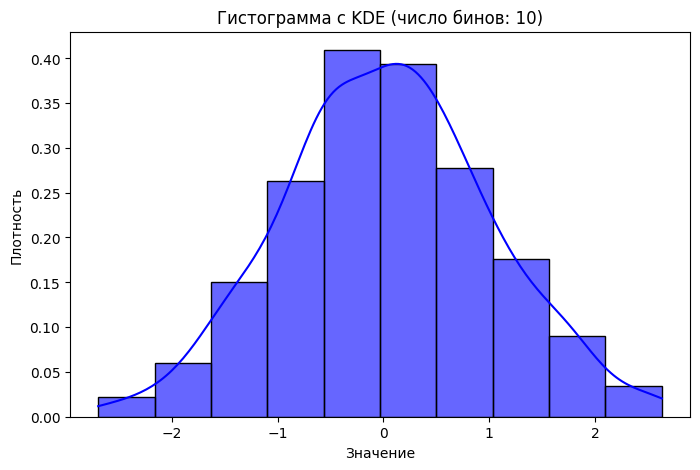

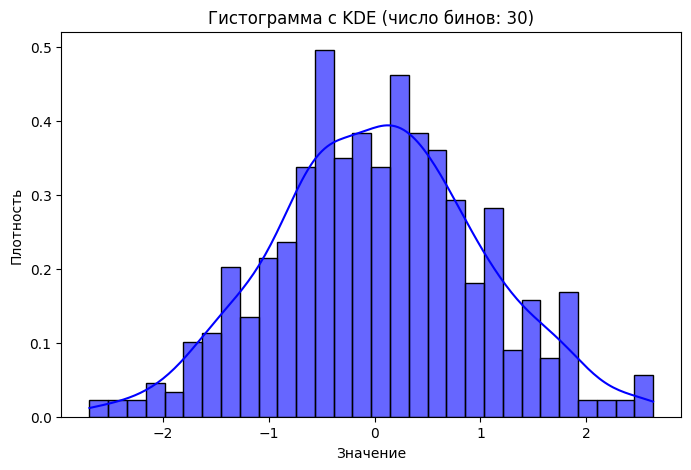

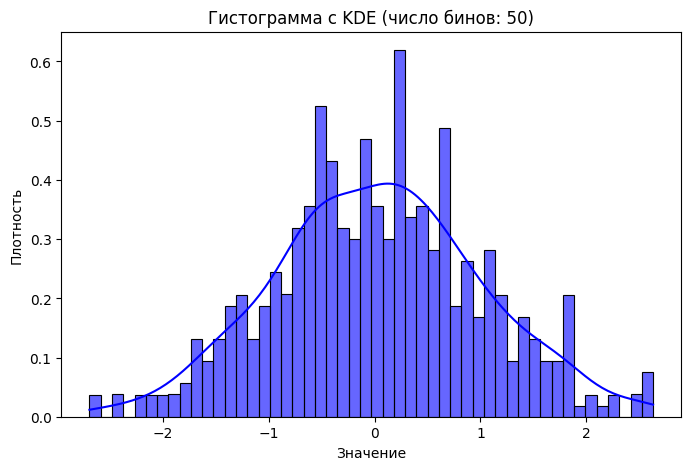

In [25]:
# Определяем три различных значения для числа бинов
bin_sizes = [10, 30, 50]

# Построение гистограмм с наложением KDE
for bins in bin_sizes:
    plt.figure(figsize=(8, 5))
    sns.histplot(sample, bins=bins, kde=True, color='blue', alpha=0.6, stat="density")
    plt.title(f'Гистограмма с KDE (число бинов: {bins})')
    plt.xlabel('Значение')
    plt.ylabel('Плотность')
    plt.show()

### 2. Бутстрап для точечных оценок

Реализуйте алгоритм бутстрапа:\
• Сгенерируйте B = 1000 бутстрап-выборок (с возвращением)\
• Для каждой выборки вычислите: среднее, медиану, дисперсию, IQR

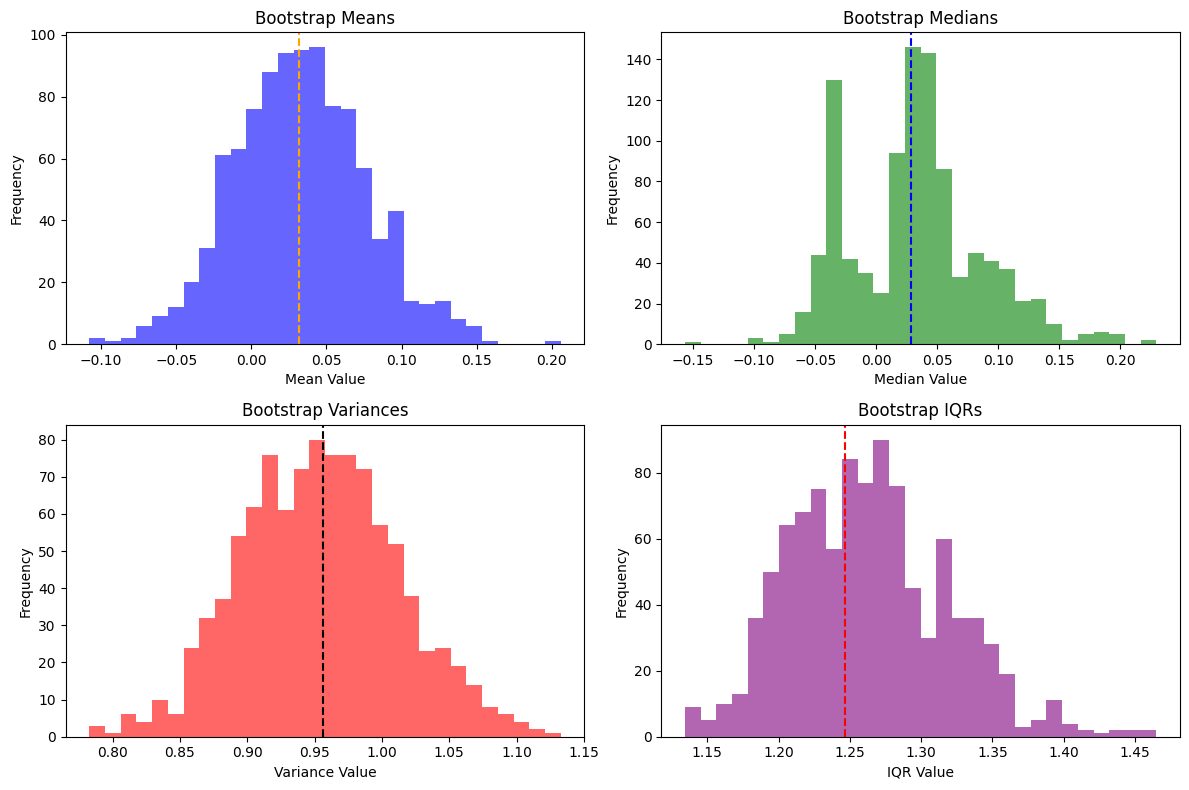

In [26]:
B = 1000

bootstrap_means = np.zeros(B)
bootstrap_medians = np.zeros(B)
bootstrap_variances = np.zeros(B)
bootstrap_iqrs = np.zeros(B)

for i in range(B):
    bootstrap_sample = np.random.choice(sample, size=N, replace=True)
    bootstrap_means[i] = np.mean(bootstrap_sample)
    bootstrap_medians[i] = np.median(bootstrap_sample)
    bootstrap_variances[i] = np.var(bootstrap_sample, ddof=1)
    bootstrap_iqrs[i] = np.percentile(bootstrap_sample, 75) - np.percentile(bootstrap_sample, 25)

plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.hist(bootstrap_means, bins=30, color='blue', alpha=0.6)
plt.axvline(x=sample_mean, color='orange', linestyle='--', label='Sample Mean')
plt.title('Bootstrap Means')
plt.xlabel('Mean Value')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
plt.hist(bootstrap_medians, bins=30, color='green', alpha=0.6)
plt.axvline(x=sample_median, color='blue', linestyle='--', label='Sample Median')
plt.title('Bootstrap Medians')
plt.xlabel('Median Value')
plt.ylabel('Frequency')

plt.subplot(2, 2, 3)
plt.hist(bootstrap_variances, bins=30, color='red', alpha=0.6)
plt.axvline(x=sample_variance, color='black', linestyle='--', label='Sample Variance')
plt.title('Bootstrap Variances')
plt.xlabel('Variance Value')
plt.ylabel('Frequency')

plt.subplot(2, 2, 4)
plt.hist(bootstrap_iqrs, bins=30, color='purple', alpha=0.6)
plt.axvline(x=sample_iqr, color='red', linestyle='--', label='Sample IQR')
plt.title('Bootstrap IQRs')
plt.xlabel('IQR Value')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

### 3. Построение доверительных интервалов
Используя процентильный метод, постройте доверительные интервалы для:\
• Среднего и медианы\
• Уровней доверия: 90% (α = 0.1), 95% (α = 0.05), 99% (α = 0.01)
(b) Визуализируйте интервалы для каждой статистики на отдельных графиках.

Доверительный интервал для среднего при alpha=0.1: [-0.03488906  0.10602059]
Доверительный интервал для медианы при alpha=0.1: [-0.04664869  0.12810441]
Доверительный интервал для дисперсии при alpha=0.1: [0.86309423 1.05246367]
Доверительный интервал для IQR при alpha=0.1: [1.18237682 1.35584858]
--------------------------------------------------


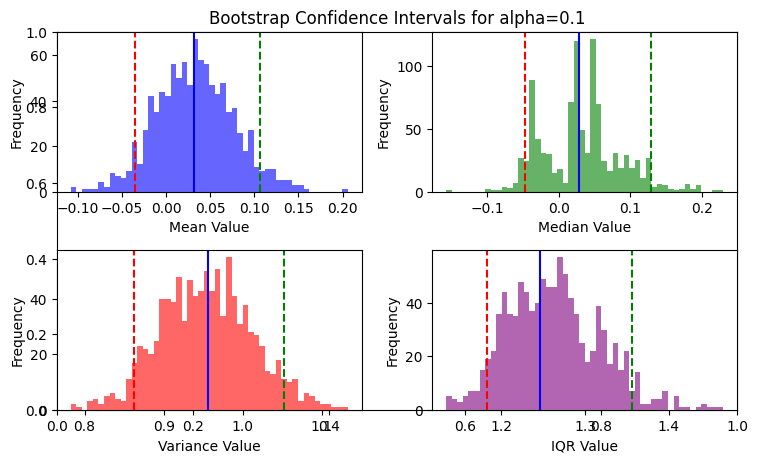

Доверительный интервал для среднего при alpha=0.05: [-0.05227095  0.12354647]
Доверительный интервал для медианы при alpha=0.05: [-0.05429487  0.14001348]
Доверительный интервал для дисперсии при alpha=0.05: [0.84349133 1.06862339]
Доверительный интервал для IQR при alpha=0.05: [1.17124016 1.38425045]
--------------------------------------------------


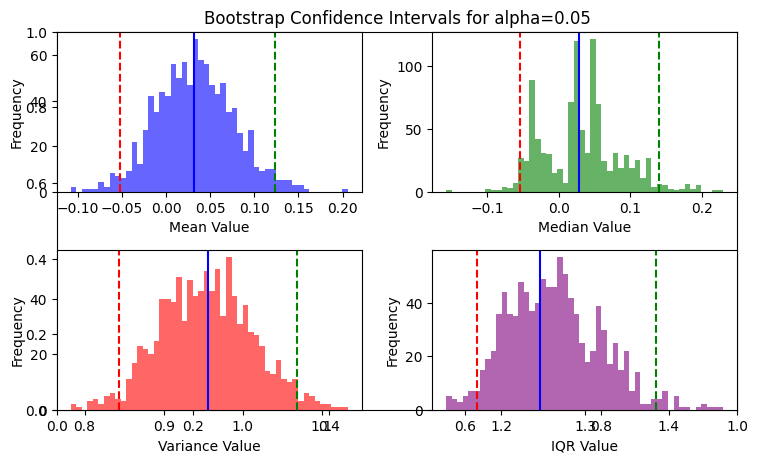

Доверительный интервал для среднего при alpha=0.01: [-0.07209386  0.14876793]
Доверительный интервал для медианы при alpha=0.01: [-0.07833056  0.19347525]
Доверительный интервал для дисперсии при alpha=0.01: [0.80888891 1.0988847 ]
Доверительный интервал для IQR при alpha=0.01: [1.14226369 1.43606653]
--------------------------------------------------


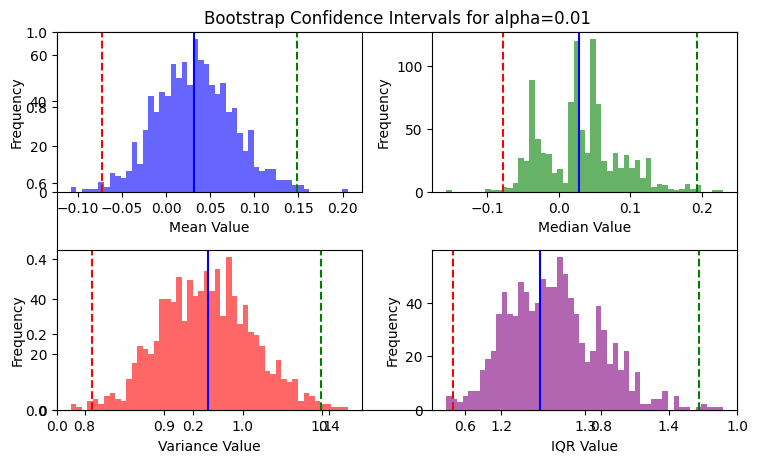

In [27]:
# Вычисление доверительных интервалов
alpha = [0.1,0.05,0.01]
for a in alpha:
    ci_mean = np.percentile(bootstrap_means, [100 * a / 2, 100 * (1 - a / 2)])
    ci_median = np.percentile(bootstrap_medians, [100 * a / 2, 100 * (1 - a / 2)])
    ci_variance = np.percentile(bootstrap_variances, [100 * a / 2, 100 * (1 - a / 2)])
    ci_iqr = np.percentile(bootstrap_iqrs, [100 * a / 2, 100 * (1 - a / 2)])

    print(f"Доверительный интервал для среднего при alpha={a}: {ci_mean}")
    print(f"Доверительный интервал для медианы при alpha={a}: {ci_median}")
    print(f"Доверительный интервал для дисперсии при alpha={a}: {ci_variance}")
    print(f"Доверительный интервал для IQR при alpha={a}: {ci_iqr}")
    print("-" * 50)

    #(b) Визуализируйте интервалы для каждой статистики на отдельных графиках. Tight layout

    plt.figure(figsize=(8, 5))
    plt.title(f'Bootstrap Confidence Intervals for alpha={a}')

    plt.subplot(2, 2, 1)
    plt.axvline(x=ci_mean[0], color='red', linestyle='--', label=f'Lower CI Mean ({a})')
    plt.axvline(x=ci_mean[1], color='green', linestyle='--', label=f'Upper CI Mean ({a})')
    plt.axvline(x=sample_mean, color='blue', linestyle='-', label='Sample Mean')
    plt.hist(bootstrap_means, bins=50, color='blue', alpha=0.6)
    plt.xlabel('Mean Value')
    plt.ylabel('Frequency')

    plt.subplot(2, 2, 2)
    plt.axvline(x=ci_median[0], color='red', linestyle='--', label=f'Lower CI Median ({a})')
    plt.axvline(x=ci_median[1], color='green', linestyle='--', label=f'Upper CI Median ({a})')
    plt.axvline(x=sample_median, color='blue', linestyle='-', label='Sample Median')
    plt.hist(bootstrap_medians, bins=50, color='green', alpha=0.6)
    plt.xlabel('Median Value')
    plt.ylabel('Frequency')

    plt.subplot(2, 2, 3)
    plt.axvline(x=ci_variance[0], color='red', linestyle='--', label=f'Lower CI Variance ({a})')
    plt.axvline(x=ci_variance[1], color='green', linestyle='--', label=f'Upper CI Variance ({a})')
    plt.axvline(x=sample_variance, color='blue', linestyle='-', label='Sample Variance')
    plt.hist(bootstrap_variances, bins=50, color='red', alpha=0.6)
    plt.xlabel('Variance Value')
    plt.ylabel('Frequency')

    plt.subplot(2, 2, 4)
    plt.axvline(x=ci_iqr[0], color='red', linestyle='--', label=f'Lower CI IQR ({a})')
    plt.axvline(x=ci_iqr[1], color='green', linestyle='--', label=f'Upper CI IQR ({a})')
    plt.axvline(x=sample_iqr, color='blue', linestyle='-', label='Sample IQR')
    plt.hist(bootstrap_iqrs, bins=50, color='purple', alpha=0.6)
    plt.xlabel('IQR Value')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

### 4. Влияние объема выборки и числа итераций

Доверительный интервал для среднего при N=50: [-0.39987398  0.18431724]
Доверительный интервал для среднего при N=100: [-0.13840722  0.21822944]
Доверительный интервал для среднего при N=200: [-0.13010114  0.14534333]
Доверительный интервал для среднего при N=500: [-0.05316331  0.13196436]
Доверительный интервал для среднего при N=1000: [-0.07231014  0.04772184]


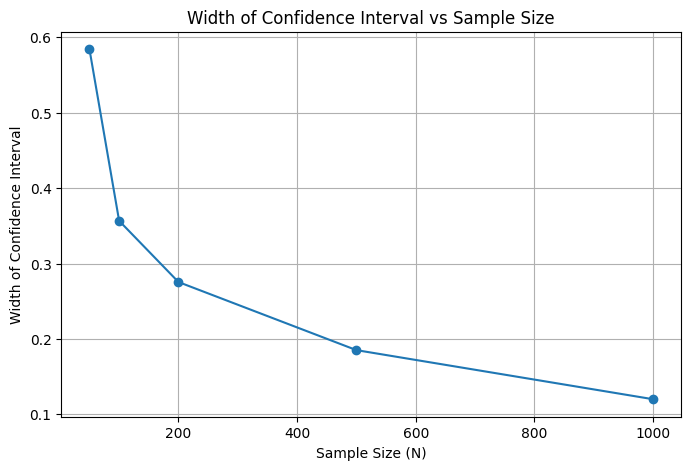

In [28]:
# Исследуйте зависимость от N :
# • Сгенерируйте выборки N = [50, 100, 200, 500, 1000]
# • Постройте 95%-доверительный интервал среднего (B = 1000)
# • Постройте график ширины интервала от N

N_values = [50, 100, 200, 500, 1000]
interval_widths = []

for N in N_values:
    sample = np.random.normal(loc=mean, scale=std_dev, size=N)
    bootstrap_means = np.zeros(B)

    for i in range(B):
        bootstrap_sample = np.random.choice(sample, size=N, replace=True)
        bootstrap_means[i] = np.mean(bootstrap_sample)

    ci_mean = np.percentile(bootstrap_means, [2.5, 97.5])
    interval_widths.append(ci_mean[1] - ci_mean[0])
    print(f"Доверительный интервал для среднего при N={N}: {ci_mean}")

plt.figure(figsize=(8, 5))
plt.plot(N_values, interval_widths, marker='o')
plt.title('Width of Confidence Interval vs Sample Size')
plt.xlabel('Sample Size (N)')
plt.ylabel('Width of Confidence Interval')
plt.grid()
plt.show()

Доверительный интервал для среднего при B=100: [-0.09862261  0.0763594 ]
Доверительный интервал для среднего при B=200: [-0.15513256  0.00143382]
Доверительный интервал для среднего при B=400: [-0.00451403  0.13963807]
Доверительный интервал для среднего при B=1600: [-0.01391339  0.14920449]
Доверительный интервал для среднего при B=3200: [-0.1423217   0.03039985]


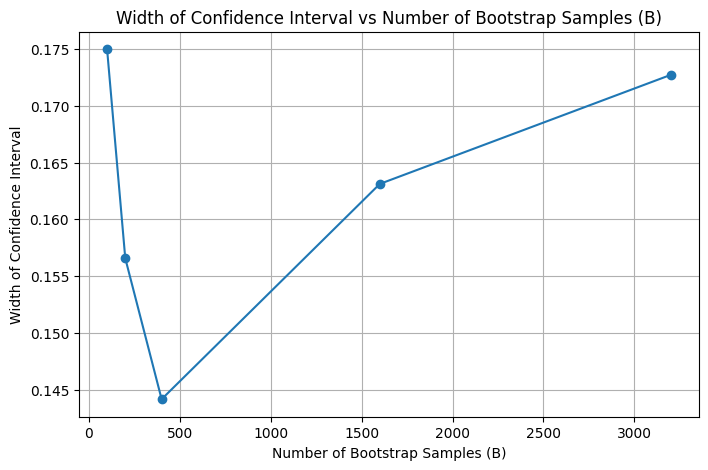

In [29]:
# Исследуйте зависимость от B:
# • Для N = 500 выберите B = [100, 200, 400, 1600, 3200]
# • Постройте 95%-доверительный интервал среднего
# • Визуализируйте изменение ширины интервала

B_values = [100, 200, 400, 1600, 3200]
interval_widths_B = []
N = 500

for B in B_values:
    sample = np.random.normal(loc=mean, scale=std_dev, size=N)
    bootstrap_means = np.zeros(B)

    for i in range(B):
        bootstrap_sample = np.random.choice(sample, size=N, replace=True)
        bootstrap_means[i] = np.mean(bootstrap_sample)

    ci_mean = np.percentile(bootstrap_means, [2.5, 97.5])
    interval_widths_B.append(ci_mean[1] - ci_mean[0])
    print(f"Доверительный интервал для среднего при B={B}: {ci_mean}")

plt.figure(figsize=(8, 5))
plt.plot(B_values, interval_widths_B, marker='o')
plt.title('Width of Confidence Interval vs Number of Bootstrap Samples (B)')
plt.xlabel('Number of Bootstrap Samples (B)')
plt.ylabel('Width of Confidence Interval')
plt.grid()
plt.show()

### 4. Проверка покрытия интервалов

Processing N=50, B=3200:   0%|          | 0/5 [00:00<?, ?it/s]

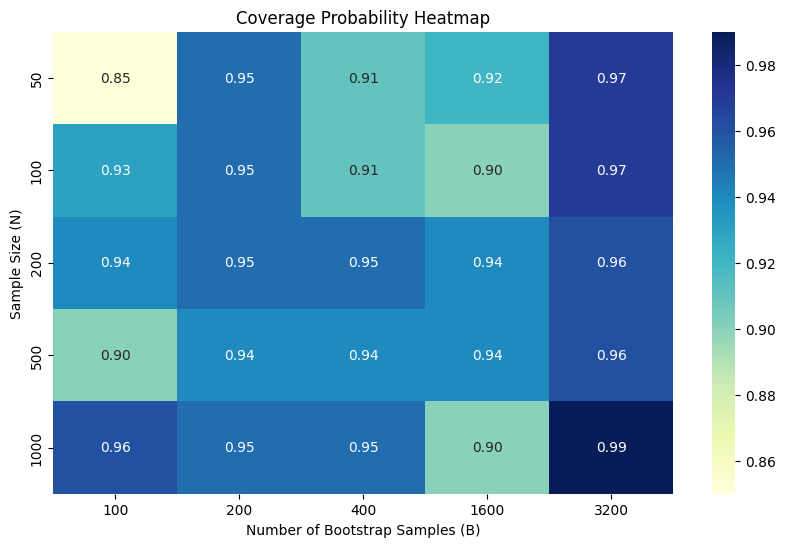

In [33]:
# Для N (0, 1):
# • Сгенерируйте 100 выборок N = [50, 100, 200, 500, 1000]
# • Постройте 95%-доверительный интервал среднего B = [100, 200, 400, 1600, 3200]
# • Определите долю интервалов, содержащих μ = 0
# Результаты оформите в таблицу:
# Объем выборки N Число итераций B Доля покрытия
# 50 1000 0.92
# 100 1000 0.95
# 200 1000 0.96
# (c) Постройте heatmap с этими данными.


N_values = [50, 100, 200, 500, 1000]
B_values = [100, 200, 400, 1600, 3200]

# Матрица для хранения доли покрытия
coverage = np.zeros((len(N_values), len(B_values)))

# Генерация выборок и построение доверительных интервалов
# Use tqdm to show progress
for i in range(len(N_values)):
    for j in tqdm(range(len(B_values)), desc=f"Processing N={N_values[i]}, B={B_values[j]}", leave=False):
        count_coverage = 0
        for _ in range(100):  # 100 выборок
            sample = np.random.normal(loc=mean, scale=std_dev, size=N_values[i])
            bootstrap_means = np.zeros(B_values[j])

            for k in range(B_values[j]):
                bootstrap_sample = np.random.choice(sample, size=N_values[i], replace=True)
                bootstrap_means[k] = np.mean(bootstrap_sample)

            ci_mean = np.percentile(bootstrap_means, [2.5, 97.5])
            if ci_mean[0] <= mean <= ci_mean[1]:
                count_coverage += 1

        coverage[i, j] = count_coverage / 100


plt.figure(figsize=(10, 6))
sns.heatmap(coverage, annot=True, fmt=".2f", cmap="YlGnBu", xticklabels=B_values, yticklabels=N_values)
plt.title('Coverage Probability Heatmap')
plt.xlabel('Number of Bootstrap Samples (B)')
plt.ylabel('Sample Size (N)')
plt.show()


In [31]:
# Вывести результаты в виде таблицы
coverage_df = pd.DataFrame(coverage, index=N_values, columns=B_values)
coverage_df.index.name = 'Sample Size (N)'
coverage_df.columns.name = 'Number of Bootstrap Samples (B)'
coverage_df

Number of Bootstrap Samples (B),100,200,400,1600,3200
Sample Size (N),,,,,
50,0.95,0.96,0.96,0.95,0.93
100,0.93,0.93,0.94,0.93,0.94
200,0.90,0.89,0.94,0.95,0.92
500,0.89,0.92,0.95,0.94,0.97
1000,0.89,0.91,0.95,0.95,0.94


## Выводы и заключение
---
